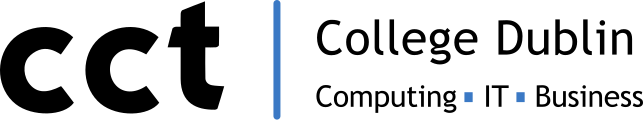

<div style="text-align: center;">
    <h2><u>Capstone Pair Project</u></h2>
    <h3> Problem Solving for Industry</h3>
    <h3>Supervisor: Dr Muhammad Iqbal</h3>
    <h3>Student Names: Danrlei Martins & Leonardo Diesel</h3>
    <h3>Student Numbers: 2020322 & 2020302</h3>
    <h3><a href="https://github.com/danrlei-martins-cct/CCT-Capstone-Project-FER">GitHub Repository</a></h3>
</div>

***

### Install Libraries

In [ ]:
# pip install keras
# pip install tensorflow
# pip install keras-tuner --upgrade

### Import Libraries

In [10]:
import os
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import keras
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.layers import Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from kerastuner.tuners import RandomSearch

### Libraries Explanation


***

## 1. Data Understanding

In [2]:
train_dir = "FER2013/train/" # path with training images
test_dir = "FER2013/test/"   # path with testing images

In [3]:
# Exploring the different expressions (categories) of the FER2013 dataset
train_expressions = os.listdir(train_dir)
test_expressions = os.listdir(test_dir)

print("Expression Categories in Training Images:", train_expressions)
print("Expression Categories in Testing Images:", test_expressions)

Expression Categories in Training Images: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Expression Categories in Testing Images: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
# Dictionaries to store the image counts
train_image_counts = {expr: 0 for expr in train_expressions}
test_image_counts = {expr: 0 for expr in test_expressions}

# Count the number of images for each expression category
for expr in train_expressions:
    train_image_counts[expr] = len(os.listdir(os.path.join(train_dir, expr)))

for expr in test_expressions:
    test_image_counts[expr] = len(os.listdir(os.path.join(test_dir, expr)))
    
# Calculate the total number of images in the training and testing sets
total_train_images = sum(train_image_counts.values())
total_test_images = sum(test_image_counts.values())

# Print the results
print("\nNumber of Images per Category in Training Set:")
for expr, count in train_image_counts.items():
    print(f"{expr}: {count}")
print(f"Total Training Images: {total_train_images}")

print("\nNumber of Images per Category in Testing Set:")
for expr, count in test_image_counts.items():
    print(f"{expr}: {count}")
print(f"Total Testing Images: {total_test_images}")


Number of Images per Category in Training Set:
angry: 3995
disgust: 436
fear: 4097
happy: 7215
neutral: 4965
sad: 4830
surprise: 3171
Total Training Images: 28709

Number of Images per Category in Testing Set:
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831
Total Testing Images: 7178


### 1.1 Exploratory Data Analysis (EDA)

In [ ]:
# Plot the distribution of expression categories in the sets
plt.figure(figsize=(8, 6))
plt.bar(train_image_counts.keys(), train_image_counts.values(), color='red')
plt.title("Distribution of Expression Categories in Training Set")
plt.xlabel("Expression Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=90);

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(test_image_counts.keys(), test_image_counts.values())
plt.title("Distribution of Expression Categories in Testing Set")
plt.xlabel("Expression Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

In [ ]:
def visualize_img_samples(directory, num_samples_per_category):
    
    # Get the expression categories from the training directory
    train_expressions = os.listdir(train_dir)
    
    # Create a figure with subplots for each expression category
    fig, axes = plt.subplots(nrows=len(train_expressions), ncols=num_samples_per_category, figsize=(10, 10))
    
    # Iterate over the expression categories
    for i, expr in enumerate(train_expressions):
        # Get the path to the expression directory
        expr_dir = os.path.join(train_dir, expr)
        
        # Get the image files in the expression directory
        expr_files = os.listdir(expr_dir)
        
        # Randomly select sample images
        sample_image_files = random.sample(expr_files, num_samples_per_category)
        
        # Display the sample images
        for j, sample_image_file in enumerate(sample_image_files):
            sample_image = cv2.imread(os.path.join(expr_dir, sample_image_file))
            axes[i, j].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            axes[i, j].set_title(expr)
            axes[i, j].axis('off')
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.001)
    
    # Display the figure
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_img_samples(train_dir, 6)

### 1.2 Findings

FER-2013 is an image contained dataset, all in 48x48 dimension where the faces were automatically registered, being centralized and categorized by emotions. There is an amount of 35,887 images, or faces, in this dataset and they are categorized by Angry (0), Disgust (1), Fear (2), Happy (3), Sad (4), Surprise (5) and Neutral (6). In these first steps we performed for the data understanding, two aspects strucked us; data imbalance and data accuracy.

For the first observations, it is clear that are imbalances in the dataset as the gap between the amount of images for the emotions Happy and Disgust is quite notable. 547 is the amount of images in the Disgust category and in contrast we find 8,989 images for the other category. There is as well a gap between Happy and the other remaining categories, which is not as big as the one just pointed, giving room for a possible balance in this amount what would may give less bias and overfitting to the future model, but as the first gap is quite large this balance might not be the best option. The best option is to train the model and see how it performs and with the results we are able to decide which way to go.

The accuracy aspect of the data comes when we sample a few random images from each of the emotions and could observe that not all of the images were accurate to their emotions. In some cases images/faces placed in the Happy category did not look to be a happy face, but a neutral, or a image place in the Fear category that does not resamble with the category. These are aspects that could change the accuracy of the model after the  training.

***

## 2. Data Preparation

### 2.1 Data Augmentation

In [5]:
# Define the preprocessing parameters for data augmentation
train_datagen = ImageDataGenerator(
    rescale = 1 / 255.,        # Rescale pixel values to [0, 1] range
    rotation_range = 15,       # Randomly rotate images by 0-20 degrees
    zoom_range = 0.1,          # Zoom to our object randomly
    horizontal_flip = True,    # Randomly flip images horizontally
    height_shift_range = 0.1,  # Shift the height of images by up to 10% randomly
    width_shift_range = 0.1,   # Shift the width of images by up to 10% randomly
    fill_mode = 'nearest',     # Replaces the empty area with the nearest pixel values
    validation_split = 0.2     # Set the validation split to 20%
)

test_datagen = ImageDataGenerator(
    rescale = 1 / 255.  # Rescale pixel values to [0, 1] range
)

In [ ]:
def visualize_augmentation(train_datagen, train_dir, num_samples=10):

    # Get the expression categories from the training directory
    expression_categories = os.listdir(train_dir)
    
    # Create a figure with subplots for each expression category
    fig, axes = plt.subplots(nrows=len(expression_categories), ncols=num_samples + 1, figsize=(10, 10))
    
    # Iterate over the expression categories
    for i, expr in enumerate(expression_categories):
        # Get the path to the expression directory
        expr_dir = os.path.join(train_dir, expr)
        
        # Get the image files in the expression directory
        expr_files = os.listdir(expr_dir)
        
        # Randomly select a sample image
        sample_image_file = random.choice(expr_files)
        sample_image = cv2.imread(os.path.join(expr_dir, sample_image_file))
        
        # Display the original sample image
        axes[i, 0].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title(f"Original ({expr})")
        axes[i, 0].axis('off')
        
        # Apply data augmentation and display the transformed images
        for j in range(1, num_samples + 1):
            # Apply data augmentation to the sample image
            augmented_image = train_datagen.random_transform(sample_image)
            
            # Display the transformed image
            axes[i, j].imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
            axes[i, j].set_title(f"Augmented ({j})")
            axes[i, j].axis('off')
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.001)
    
    # Display the figure
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_augmentation(train_datagen, train_dir, num_samples=5)

### 2.2 Preparing Training, Validation & Testing Sets with Keras Generators

In [6]:
# Specify the target size for images
img_size = 48

# Set the batch size for training
batch_size = 64

In [7]:
# Load the training data using flow_from_directory
print('Training Set: ', end = '')
train_generator = train_datagen.flow_from_directory(
    train_dir,                                # Path to the training image directory
    target_size = (img_size, img_size),       # Resize all images to target size
    batch_size = batch_size,                  # Number of images to be processed in each batch
    shuffle = True,                           # Shuffle the training data for each epoch
    class_mode='categorical',                 # Output labels will be one-hot encoded
    color_mode = 'rgb',                       # Load images in RGB color mode
    subset = 'training'                       # Use the training subset of the directory
)

# Load the validation data using flow_from_directory
print('Validation Set: ', end = '')
validation_generator = train_datagen.flow_from_directory(
    train_dir,                                # Path to the training image directory
    target_size = (img_size, img_size),       # Resize all images to target size
    batch_size = batch_size,                  # Number of images to be processed in each batch
    shuffle = False,                          # Do not shuffle the validation data
    class_mode='categorical',                 # Output labels will be one-hot encoded
    color_mode = 'rgb',                       # Load images in RGB color mode
    subset = 'validation'                     # Use the validation subset of the directory
)

# Load the testing data using flow_from_directory
print('Testing Set: ', end = '')
test_generator = test_datagen.flow_from_directory(
    test_dir,                                 # Path to the testing image directory
    target_size = (img_size, img_size),       # Resize all images to target size
    batch_size = batch_size,                  # Number of images to be processed in each batch
    shuffle = True,                           # Shuffle the testing data
    class_mode='categorical',                 # Output labels will be one-hot encoded
    color_mode = 'rgb',                       # Load images in RGB color mode
    subset = None                             # No subset for this directory
)

Training Set: Found 22968 images belonging to 7 classes.
Validation Set: Found 5741 images belonging to 7 classes.
Testing Set: Found 7178 images belonging to 7 classes.


---

## 3. Modeling

In [ ]:
# Create the base pre-trained VGG16 model
# Source: https://keras.io/api/applications/vgg/
base_model = VGG16(input_shape=(img_size, img_size, 3), # Specify the input shape for the VGG16 model
                   include_top=False,                   # Exclude the top (classification) layer
                   pooling='avg',                       # Use global average pooling
                   weights="imagenet")                  # Load pre-trained weights from ImageNet

# Flatten the output from the base model
x = Flatten()(base_model.output)

# Add a dense layer with 7 units and softmax activation
x = Dense(7, activation='softmax')(x)

# Create the final model with the base model input and the new output layer
model = Model(base_model.input, x)

# Create an Adam optimizer instance with a learning rate of 0.001
optimizer = Adam(learning_rate=0.001)

# Compile the model with the specified optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print a summary of the model architecture
model.summary()

In [ ]:
# Plot the model architecture as a sequential diagram
tf.keras.utils.plot_model(model)

In [ ]:
# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning if the model loss does not decrease
# Source: https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',      # Monitor the validation loss
    factor = 0.5,              # Reduce the learning rate by a factor of 0.5
    patience = 10,             # Wait for 10 epochs before reducing the learning rate
    min_lr = 0.00001,          # Set a minimum learning rate of 0.00001
    verbose = 1                # Print a message when the learning rate is reduced
)

# Create Early Stopping Callback to monitor the accuracy
# Source: https://keras.io/api/callbacks/early_stopping/
early_stopping = EarlyStopping(
    monitor = 'val_loss',         # Monitor the validation loss
    min_delta = 0.005,            # Minimum change in the monitored quantity to qualify as an improvement
    patience = 10,                # Wait for 10 epochs before stopping
    verbose = 1,                  # Print a message when the training is stopped
    restore_best_weights = True   # Restore the best model weights after stopping
)

# Combine the callbacks into a list
callbacks = [reduce_lr, early_stopping]

In [ ]:
# Start model training
history = model.fit(
    train_generator,                          # Pass the training data generator
    validation_data = validation_generator,   # Pass the validation data generator
    epochs = 40,                              # Set the number of epochs to train for
    callbacks = callbacks,                    # Pass the list of callbacks
    verbose = 1                               # Set the verbosity level to 1 (print progress)
)

In [ ]:
# Evaluate the model on the training set
train_loss, train_acc = model.evaluate(train_generator)

# Evaluate the model on the validation set
test_loss, test_acc = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc * 100, test_acc * 100))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

In [ ]:
# Define the emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Get the true labels and predicted labels for the validation set
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=emotion_labels))

In [ ]:
# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

### 3.1 Hyperparameter Tuning

For matters of computational power we had to split the tunning. The first try was made to check if keras.tuner would work for our model and the second try with more parameters and more computational power was to get the best hyperparameters.

### Try Num 1

In [ ]:
# Define the hyperparameter search space
# Source: https://keras.io/keras_tuner/
def build_model(hp):
    # Load the base pre-trained VGG16 model
    base_model = VGG16(input_shape=(img_size, img_size, 3), include_top=False, pooling='avg')
    
    # Flatten the output of the VGG16 model
    x = Flatten()(base_model.output)
    
    # Add a dense layer with 7 units and softmax activation for classification
    x = Dense(7, activation='softmax')(x)
    
    # Create the final model with the VGG16 input and the new output layer
    model = Model(base_model.input, x)

    # Define the hyperparameters to tune
    # Choose the learning rate from the values [1e-2, 1e-3, 1e-4]
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    
    # Choose the batch size from the values [32, 64, 128]
    batch_size = hp.Choice('batch_size', values=[32, 64, 128])
    
    # Compile the model with the specified optimizer, loss function, and metrics
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

### Try Num 2

In [ ]:
def build_model(hp):
    # Load the base pre-trained VGG16 model
    base_model = VGG16(input_shape=(img_size, img_size, 3), include_top=False, pooling='avg')
    
    # Flatten the output of the VGG16 model
    x = Flatten()(base_model.output)
    
    # Add dense layers with varying number of units
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        x = Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu')(x)
        x = Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1))(x)
    
    # Add a dense layer with 7 units and softmax activation for classification
    x = Dense(7, activation='softmax')(x)
    
    # Create the final model with the VGG16 input and the new output layer
    model = Model(base_model.input, x)

    # Define the hyperparameters to tune
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    
    # Choose the batch size from the values [32, 64, 128]
    batch_size = hp.Choice('batch_size', values=[32, 64, 128, 256])
    
    # Compile the model with the specified optimizer, loss function, and metrics
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
# Instantiate the tuner
# Source: https://keras.io/keras_tuner/
tuner = kt.RandomSearch(
    build_model,             # The function that builds the model with hyperparameters
    objective='val_accuracy',  # The metric to optimize during tuning
    max_trials=10,             # The maximum number of trial models to evaluate
    directory='tuning_dir',    # The directory to save the tuning results
    project_name='my_tuning'   # The name of the tuning project
)

In [ ]:
# Search for the best hyperparameters
# Source: https://keras.io/keras_tuner/
tuner.search(train_generator,                       # Pass the training data generator
             validation_data=validation_generator,  # Pass the validation data generator
             epochs=10,                             # Set the number of epochs to train for each trial
             callbacks=callbacks)                   # Pass the list of callbacks to use during training

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

In [ ]:
best_hyperparameters = best_hps.values

print("Best Hyperparameters:")
print(best_hyperparameters)

## Custom model with best HP

Finding the best hyperparameters we now went on creating a custon model using them.

In [8]:
best_hyperparameters = {
    'num_layers': 3,
    'units_0': 224,
    'dropout_0': 0.1,
    'learning_rate': 0.0001,
    'batch_size': 128,
    'units_1': 352,
    'dropout_1': 0.3,
    'units_2': 32,
    'dropout_2': 0.2
}

In [11]:
# Create the base pre-trained VGG16 model
base_model = VGG16(input_shape=(img_size, img_size, 3), # Specify the input shape for the VGG16 model
                   include_top=False,                   # Exclude the top (classification) layer
                   pooling='avg',                       # Use global average pooling
                   weights="imagenet")                  # Load pre-trained weights from ImageNet

# Flatten the output from the base model
x = Flatten()(base_model.output)

# Add dense layers with best hyperparameters for each layer
for i in range(best_hyperparameters['num_layers']):
    x = Dense(units=best_hyperparameters[f'units_{i}'], activation='relu')(x)
    x = Dropout(rate=best_hyperparameters[f'dropout_{i}'])(x)

# Add a dense layer with 7 units and softmax activation
x = Dense(7, activation='softmax')(x)

# Create the final model with the base model input and the new output layer
custom_model = Model(base_model.input, x)

# Create an Adam optimizer instance with the best learning rate
optimizer = Adam(learning_rate=best_hyperparameters['learning_rate'])

# Compile the model with the specified optimizer, loss function, and metrics
custom_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Print a summary of the model architecture
custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

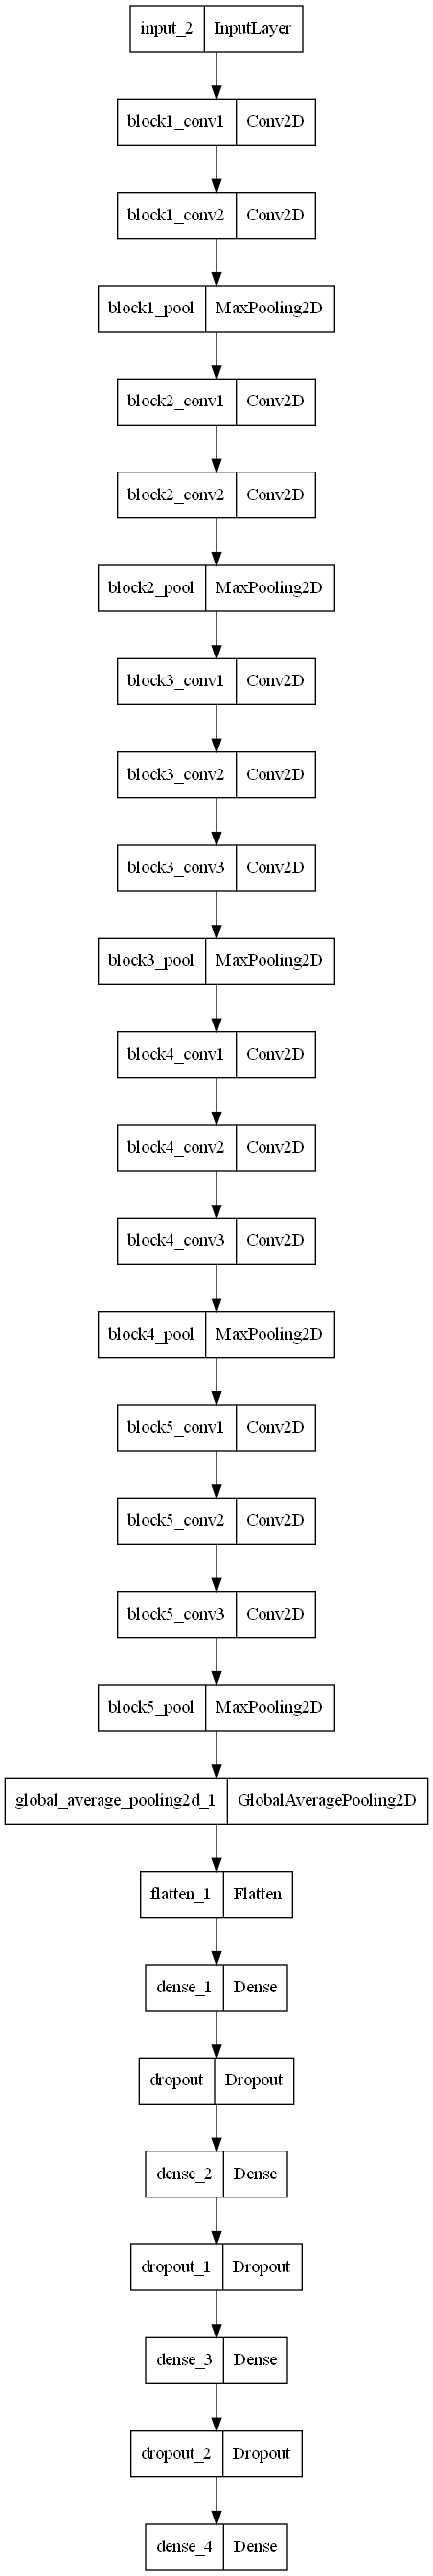

In [14]:
# Plot the model architecture as a sequential diagram
tf.keras.utils.plot_model(custom_model)

In [15]:
# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning if the model loss does not decrease
# Source: https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',      # Monitor the validation loss
    factor = 0.5,              # Reduce the learning rate by a factor of 0.5
    patience = 10,             # Wait for 10 epochs before reducing the learning rate
    min_lr = 0.00001,          # Set a minimum learning rate of 0.00001
    verbose = 1                # Print a message when the learning rate is reduced
)

# Create Early Stopping Callback to monitor the accuracy
# Source: https://keras.io/api/callbacks/early_stopping/
early_stopping = EarlyStopping(
    monitor = 'val_loss',         # Monitor the validation loss
    min_delta = 0.005,            # Minimum change in the monitored quantity to qualify as an improvement
    patience = 10,                # Wait for 10 epochs before stopping
    verbose = 1,                  # Print a message when the training is stopped
    restore_best_weights = True   # Restore the best model weights after stopping
)

# Combine the callbacks into a list
callbacks = [reduce_lr, early_stopping]

In [17]:
# Start model training
history = custom_model.fit(
    train_generator,                          # Pass the training data generator
    validation_data = validation_generator,   # Pass the validation data generator
    epochs = 40,                              # Set the number of epochs to train for
    callbacks = callbacks,                    # Pass the list of callbacks
    verbose = 1                               # Set the verbosity level to 1 (print progress)
)

Epoch 1/40
359/359 [==============================] - 761s 2s/step - loss: 1.6519 - accuracy: 0.3459 - val_loss: 1.4358 - val_accuracy: 0.4370 - lr: 1.0000e-04
Epoch 2/40
359/359 [==============================] - 764s 2s/step - loss: 1.4088 - accuracy: 0.4656 - val_loss: 1.3489 - val_accuracy: 0.5039 - lr: 1.0000e-04
Epoch 3/40
359/359 [==============================] - 764s 2s/step - loss: 1.2952 - accuracy: 0.5264 - val_loss: 1.2289 - val_accuracy: 0.5478 - lr: 1.0000e-04
Epoch 4/40
359/359 [==============================] - 783s 2s/step - loss: 1.2173 - accuracy: 0.5600 - val_loss: 1.1480 - val_accuracy: 0.5804 - lr: 1.0000e-04
Epoch 5/40
359/359 [==============================] - 773s 2s/step - loss: 1.1561 - accuracy: 0.5811 - val_loss: 1.1289 - val_accuracy: 0.5874 - lr: 1.0000e-04
Epoch 6/40
359/359 [==============================] - 774s 2s/step - loss: 1.1136 - accuracy: 0.6024 - val_loss: 1.0835 - val_accuracy: 0.5968 - lr: 1.0000e-04
Epoch 7/40
359/359 [====================

In [19]:
# Evaluate the model on the training set
train_loss, train_acc = custom_model.evaluate(train_generator)

# Evaluate the model on the validation set
test_loss, test_acc = custom_model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc * 100, test_acc * 100))

# Evaluate the model on the test set
test_loss, test_acc = custom_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

90/90 [==============================] - 35s 388ms/step - loss: 1.0174 - accuracy: 0.6323
final train accuracy = 72.40 , validation accuracy = 63.23
113/113 [==============================] - 40s 353ms/step - loss: 0.9850 - accuracy: 0.6516
Test accuracy: 65.16%


Results:

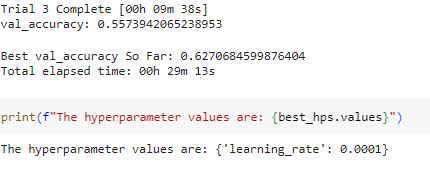

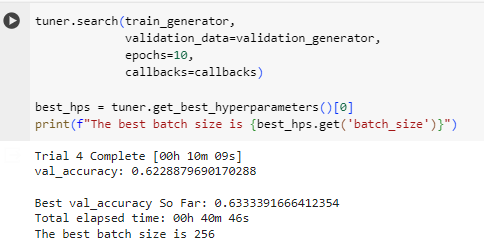

### 3.2 Custom VGG16 Model